Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0376 - val_loss: 0.0016
Epoch 2/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0054 - val_loss: 0.0012
Epoch 3/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 4/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0024 - val_loss: 7.3366e-04
Epoch 5/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0019 - val_loss: 5.0643e-04
Epoch 6/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0014 - val_loss: 3.6532e-04
Epoch 7/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0012 - val_loss: 5.4528e-04
Epoch 8/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0011 - val_loss: 2.7198e-04
Epoch 9/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0011 - val_loss: 2.7515e-04
Epoch 10/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.6104e-04 - val_loss: 2.5033e-04
Epoch 11/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 9.6215e-04 - val_loss: 4.5165e-04
Epoch 12/40
900/900 ━━━

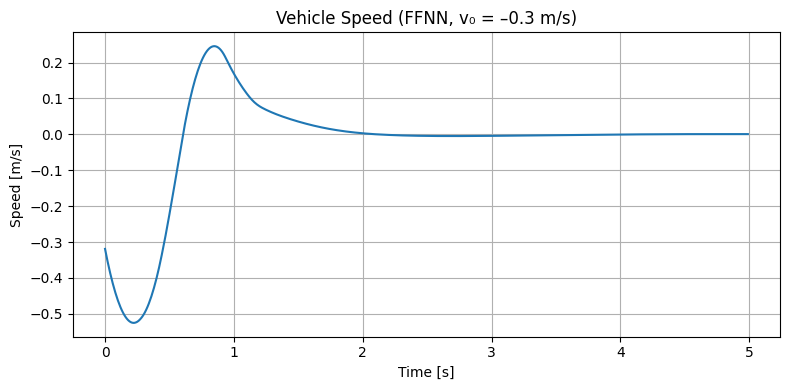

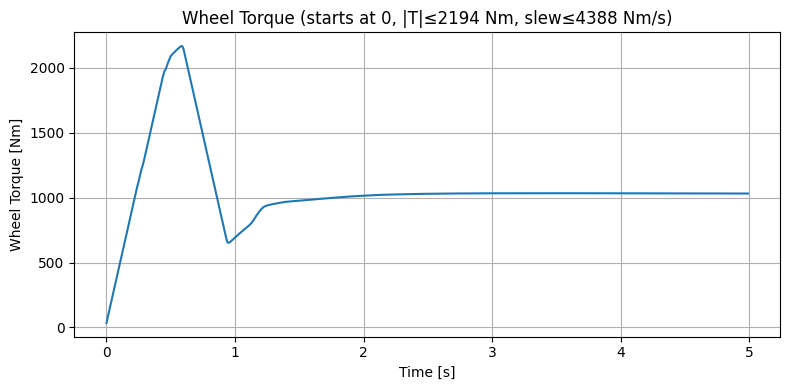

In [3]:
# hill_assist_ffnn_slew_teacher.py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# ───────────────────────── 0) Sabitler ─────────────────────────
np.random.seed(42); tf.random.set_seed(42)

m, r_tire, g = 1500.0, 0.35, 9.81
theta = np.deg2rad(11.5)
F_dist = m*g*np.sin(theta) + 14.0          # eğim + yuvarlanma

gear_ratio, eff = 12.5, 0.90
T_MAX  = 150 * gear_ratio * eff * 1.30     # ≈ 2 194 Nm
T_SLEW = 2 * T_MAX                         # ≈ 4 388 Nm s⁻¹

# “öğretmen” PID kazançları
Kp, Ki, Kd = 4_000.0, 8_000.0, 80.0

# zaman tabanı
dt, t_end = 0.01, 5.0
N = int(t_end/dt)
time = np.arange(N)*dt

# yardımcı: slew-rate filtresi
def slew_filter(T_cmd, T_act):
    dT_allowed = T_SLEW * dt
    return T_act + np.clip(T_cmd - T_act, -dT_allowed, dT_allowed)

# ─────────── 1) PID “öğretmeni” ile veri üret ───────────
def run_pid_episode(v0):
    v, int_e, prev_e, T_act = v0, 0.0, 0.0, 0.0
    X, y = [], []
    for _ in range(N):
        e   = -v                      # v_ref = 0
        int_e += e*dt
        de  = (e - prev_e)/dt
        prev_e = e

        T_cmd = np.clip(Kp*e + Ki*int_e + Kd*de, -T_MAX, T_MAX)
        T_act = slew_filter(T_cmd, T_act)

        v += ((T_act / r_tire) - F_dist) / m * dt

        X.append([v, e, int_e, de])
        y.append([T_act])             # uygulanmış (0’dan başlayan) tork
    return np.array(X), np.array(y)

# veri seti: 6 başlangıç hızı × 12 varyasyon
init_speeds = [0.0, -0.1, -0.2, -0.4, -0.6, -0.8]
episodes = [run_pid_episode(v0 + np.random.normal(0, 0.02))
            for v0 in init_speeds for _ in range(12)]

X_all = np.vstack([ep[0] for ep in episodes])
y_all = np.vstack([ep[1] for ep in episodes])

# ölçekleme
x_scaler = MinMaxScaler();  X_scaled = x_scaler.fit_transform(X_all)
y_scaler = MinMaxScaler();  y_scaled = y_scaler.fit_transform(y_all)

X_tr, X_te, y_tr, y_te = train_test_split(
    X_scaled, y_scaled, test_size=0.2, shuffle=True, random_state=42
)

# ─────────── 2) FFNN modeli & eğitim ───────────
model = Sequential([
    Dense(64, 'relu', input_shape=(4,)),
    Dropout(0.2),
    Dense(32, 'relu'),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_tr, y_tr, epochs=40, batch_size=32,
          validation_data=(X_te, y_te), verbose=1)

# ─────────── 3) FFNN ile simülasyon (v0 = –0.3 m/s) ───────────
def simulate_with_nn(v0):
    v, int_e, prev_e, T_act = v0, 0.0, 0.0, 0.0
    v_log, T_log = np.zeros(N), np.zeros(N)

    for k in range(N):
        e   = -v
        int_e += e*dt
        de  = (e - prev_e)/dt
        prev_e = e

        # ağ tahmini → satürasyon
        T_cmd = y_scaler.inverse_transform(
                    model.predict(x_scaler.transform([[v, e, int_e, de]]),
                                  verbose=0)
                 )[0, 0]
        T_cmd = np.clip(T_cmd, -T_MAX, T_MAX)

        # slew-rate filtresi
        T_act = slew_filter(T_cmd, T_act)

        v += ((T_act / r_tire) - F_dist) / m * dt
        v_log[k], T_log[k] = v, T_act
    return v_log, T_log

v_nn, T_nn = simulate_with_nn(-0.3)

# ─────────── 4) Grafikler ───────────
plt.figure(figsize=(8,4))
plt.plot(time, v_nn)
plt.xlabel('Time [s]'); plt.ylabel('Speed [m/s]')
plt.title('Vehicle Speed (FFNN, v₀ = –0.3 m/s)')
plt.grid(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(time, T_nn)
plt.xlabel('Time [s]'); plt.ylabel('Wheel Torque [Nm]')
plt.title(f'Wheel Torque (starts at 0, |T|≤{T_MAX:.0f} Nm, slew≤{T_SLEW:.0f} Nm/s)')
plt.grid(); plt.tight_layout(); plt.show()
